In [1]:
%pylab inline
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
from jax.scipy.ndimage import map_coordinates
import h5py
'unset XLA_FLAGS'

from jax.config import config
config.update("jax_enable_x64", True)


import cmasher as cmr

Populating the interactive namespace from numpy and matplotlib


In [2]:

lognormal_params = np.loadtxt('/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/sbi_lens/sbi_lens/data/lognormal_shift.csv', skiprows=1, delimiter=',').reshape([8,8,3])



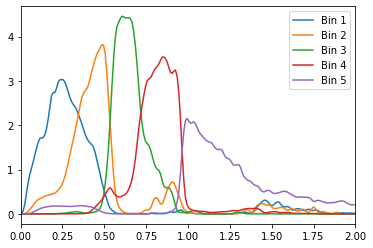

In [3]:
# Reading the DC2 tomographic bins into redshift distribution objects
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,  
                                   source[f"bin_{i}"][:], 
                                   bw=0.01, zmax=2.5) for i in range(5)] 
for i in range(5):
  plot(z_shear, nz_shear[i](z_shear), color='C%d'%i, label="Bin %d"%(i+1))
legend()
xlim(0,2);

In [4]:
# Here we add the code that interpolates the shift parameters as a function of cosmology
@jax.jit
def shift_fn(omega_m, sigma_8):
  omega_m = jnp.atleast_1d(omega_m)
  sigma_8 = jnp.atleast_1d(sigma_8) 
  return map_coordinates(lognormal_params[:,:,2], jnp.stack([(omega_m - 0.2) / 0.2*8 - 0.5,
                                                             (sigma_8 - 0.6) / 0.4*8 - 0.5], 
                                                            axis=0).reshape([2,-1]) , order=1, mode='nearest').squeeze()

In [5]:
def make_power_map(pk_fn, N, map_size, zero_freq_val=0.0, model_type=None ):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=map_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    if model_type=='no_correlation':
        power_map = ps_map * (N / map_size)**2
    elif model_type=='no_norm':
        power_map = ps_map 
    else:
        power_map = ps_map * (N / map_size)
    return power_map

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    power_spectrum_for_lognorm = jnp.log(1 +
                                         power_spectrum_for_lognorm / shift**2)
    power_spectrum_for_lognorm = jnp.abs(
        jnp.fft.fft2(power_spectrum_for_lognorm))
    power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0, 0].set(0.)
    return  power_spectrum_for_lognorm


def make_lognormal_cl(cl,shift):
    xsi = jnp.fft.ifft(cl).real
    xsi_shift = jnp.log(1 + xsi/(shift)**2)
    cl_shifted =  jnp.abs(jnp.fft.fft(xsi_shift))
    cl_shifted=cl_shifted.at[0].set(0.)
    return  cl_shifted



In [171]:
N=128            
map_size=5   
pix_area = (map_size * 60 / N)**2 # arcmin2 
map_size = map_size / 180 * jnp.pi    # radians
omega_c = 0.3
sigma_8 =0.8
cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
ell_tab = 2 * jnp.pi * abs(jnp.fft.fftfreq(N, d=map_size / (8*N)))
tracer = jc.probes.WeakLensing([nz_shear[-1]])
shift = shift_fn(cosmo.Omega_m, sigma_8)
cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]

In [172]:
P_1 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
power_map_1 = make_power_map(P_1, N, map_size, model_type='no_correlation') 
power_map_1 = make_lognormal_power_map(power_map_1, shift)

[ 3.78694492e-04  1.56746229e-04  6.03948816e-05  3.60031747e-05
  1.66225618e-05  9.11330766e-06  3.07515628e-06  1.67698533e-06
 -3.84350241e-08 -1.12875541e-07]


In [173]:
cell_tab_shifted=make_lognormal_cl(cell_tab,shift)
P_2 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab_shifted).reshape(k.shape)
power_map_2 = make_power_map(P_2, N, map_size, model_type='no_correlation') 

[4.99040469e-11 4.56066840e-11 4.00621291e-11 3.54589720e-11
 3.13884463e-11 2.79101754e-11 2.48267781e-11 2.21248720e-11
 1.96954756e-11 1.75246648e-11]


### Create N mock realization to average over the final angular power spectrum

In [9]:
def lat_z(N=128):   
    z=numpyro.sample('z', dist.MultivariateNormal(loc=jnp.zeros((N,N)), precision_matrix=jnp.eye(N)))
    return z

In [10]:
N_sample = 20

z_list = []
key=jax.random.PRNGKey(14)
for i in range(N_sample):
    print("===================================================")
    print("Sample %d"%(i+1))
    print("===================================================")
    key,subkey=jax.random.split(key)
    sample_map_fiducial = seed(lat_z, subkey)
    z = sample_map_fiducial()
    z_list.append(z)

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18
Sample 19
Sample 20


### Compare the results with the theory

In [11]:
from lenstools import ConvergenceMap
import astropy.units as u
import itertools
import cmasher as cmr

In [12]:
ell_theory = jnp.linspace(300, 5000, 128)   
cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8)
tracer = jc.probes.WeakLensing([nz_shear[-1]])
cell_theory = jc.angular_cl.angular_cl(cosmo, ell_theory, [tracer])

In [13]:
l_edges_kmap= jnp.linspace(300, 5000, 128)


In [14]:
p_auto_sample_1=[]
p_auto_sample_2=[]
for k in range(N_sample):
    z=z_list[k]
    field_1 = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map_1)).real
    field_1 = shift * (jnp.exp(field_1 - jnp.var(field_1) / 2) - 1)
    field_2 = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map_2)).real
    field_2 = shift * (jnp.exp(field_2 - jnp.var(field_2) / 2) - 1)
    pi_1=ConvergenceMap(field_1, angle=5*u.deg).powerSpectrum(l_edges_kmap)[1]
    pi_2=ConvergenceMap(field_2, angle=5*u.deg).powerSpectrum(l_edges_kmap)[1]
    p_auto_sample_1.append(pi_1)
    p_auto_sample_2.append(pi_2)

In [15]:
Cl_auto_arr_1 =jnp.array(p_auto_sample_1)
Cl_mean_auto_1  = jnp.mean(Cl_auto_arr_1, axis=0)
Cl_lower_auto_1 = jnp.percentile(Cl_auto_arr_1, 2.5, axis=0)
Cl_upper_auto_1 = jnp.percentile(Cl_auto_arr_1, 97.5, axis=0)

In [16]:
Cl_auto_arr_2 = jnp.array(p_auto_sample_2)
Cl_mean_auto_2  = jnp.mean(Cl_auto_arr_2, axis=0)
Cl_lower_auto_2 = jnp.percentile(Cl_auto_arr_2, 2.5, axis=0)
Cl_upper_auto_2 = jnp.percentile(Cl_auto_arr_2, 97.5, axis=0)

In [17]:
ell_sample=ConvergenceMap(field_1, angle=5*u.deg).powerSpectrum(l_edges_kmap)[0]

In [18]:
col = cmr.eclipse([0.,0,0.55,0.85]) 

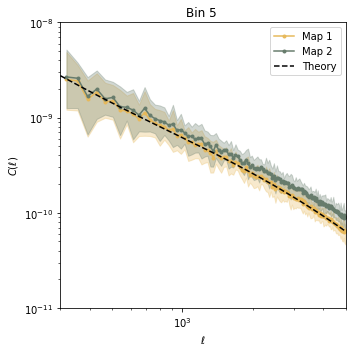

In [19]:
fig, ax = plt.subplots( figsize=(5,5))
ax.set_title('Bin %d '%(5))
ax.set_xlabel('$\ell$')
ax.set_ylabel('$C(\ell)$')
ax.set_xlim(300., 5000.)
ax.set_ylim(1e-11, 1e-8)
ax.loglog(ell_sample, Cl_mean_auto_1, '.-', color=col[3], label='Map 1')
ax.loglog(ell_sample, Cl_mean_auto_2, '.-', color=col[2], label='Map 2')
ax.loglog(ell_theory, cell_theory[0] , '--',  color=col[1], label='Theory')
ax.fill_between(ell_sample, Cl_lower_auto_1, Cl_upper_auto_1, color=col[3], alpha=0.3)
ax.fill_between(ell_sample, Cl_lower_auto_2, Cl_upper_auto_2, color=col[2], alpha=0.3)
ax.legend()
plt.tight_layout()            
plt.show()   

In [160]:
def make_power_map(pk_fn, N, map_size, zero_freq_val=0.0, model_type=None ):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=map_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    if model_type=='no_correlation':
        power_map = ps_map * (N / map_size)**2
    elif model_type=='no_norm':
        power_map = ps_map 
    else:
        power_map = ps_map * (N / map_size)
    return power_map

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    print(power_spectrum_for_lognorm[0,:10])
    power_spectrum_for_lognorm = jnp.log(1 +
                                         power_spectrum_for_lognorm / shift**2)
    power_spectrum_for_lognorm = jnp.abs(
        jnp.fft.fft2(power_spectrum_for_lognorm))
    power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0, 0].set(0.)
    return  power_spectrum_for_lognorm


def make_lognormal_cl(cl,shift):
    norm=(N / map_size)**2
    xsi = jnp.fft.ifft(cl).real
    print(xsi[:10])
    xsi_shift = jnp.log(1/norm + xsi/(shift)**2)+jnp.log(norm)
    cl_shifted =  jnp.abs(jnp.fft.fft(xsi_shift))
    cl_shifted=cl_shifted.at[0].set(0.)
    return  cl_shifted



In [161]:
P_1 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
power_map_1 = make_power_map(P_1, N, map_size, model_type='no_correlation') 
power_map_1 = make_lognormal_power_map(power_map_1, shift)

[3.96386299e-04 1.73806917e-04 7.80364731e-05 5.54865404e-05
 3.72619137e-05 2.91767869e-05 2.07029370e-05 1.59791495e-05
 1.09240581e-05 8.00719587e-06]


In [162]:
cell_tab_shifted=make_lognormal_cl(cell_tab,shift)
P_2 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab_shifted).reshape(k.shape)
power_map_2 = make_power_map(P_2, N, map_size, model_type='no_norm') 

[1.31125918e-10 1.14407978e-10 9.61203930e-11 8.32109260e-11
 7.26434259e-11 6.42794637e-11 5.71062115e-11 5.10535060e-11
 4.56667857e-11 4.09337343e-11]


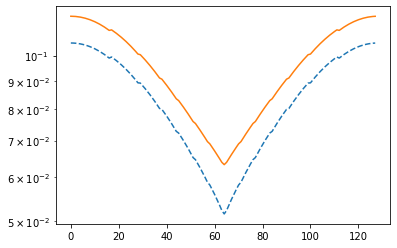

In [163]:
semilogy(power_map_1[64], '--')
semilogy(power_map_2[64])

In [170]:
power_map_1[0]-power_map_2[0]

DeviceArray([ 0.        , -0.13228122, -0.1094404 , -0.08469249,
             -0.05840787, -0.03096222, -0.00277355,  0.0257238 ,
              0.05410951,  0.04999722,  0.04531885,  0.04000987,
              0.03403668,  0.02740924,  0.02017157,  0.02486184,
              0.02081484,  0.01641887,  0.01169528,  0.01462996,
              0.01203481,  0.00925595,  0.00630112,  0.00790721,
              0.00620374,  0.0043725 ,  0.00444931,  0.00340302,
              0.00224031,  0.00098036, -0.00037551,  0.00028601,
             -0.000543  , -0.0014476 , -0.00242689, -0.00195862,
             -0.00257333, -0.00325051, -0.0039878 , -0.00364842,
             -0.00412541, -0.00465617, -0.00523868, -0.00499884,
             -0.00539268, -0.00583386, -0.00632187, -0.00617023,
             -0.00652263, -0.00691883, -0.00735906, -0.00729578,
             -0.00764171, -0.00803093, -0.00846439, -0.00849945,
             -0.00887706, -0.00930176, -0.00977666, -0.00994173,
             -0.01040715,

In [168]:
power_map_2[0]

DeviceArray([0.        , 8.17777669, 7.31447292, 6.45116914, 5.58786536,
             4.72456159, 3.86125781, 2.99795404, 2.13465026, 1.92061487,
             1.70657948, 1.4925441 , 1.27850871, 1.06447332, 0.85043793,
             0.98906781, 0.8925875 , 0.7961072 , 0.6996269 , 0.72653707,
             0.67118693, 0.61583678, 0.56048664, 0.56339443, 0.5274636 ,
             0.49153277, 0.47724851, 0.45214097, 0.42703342, 0.40192588,
             0.37681833, 0.37176455, 0.35334159, 0.33491863, 0.31649567,
             0.31134258, 0.29734291, 0.28334324, 0.26934357, 0.26456942,
             0.25364492, 0.24272042, 0.23179593, 0.22752829, 0.21882275,
             0.21011721, 0.20141166, 0.19765155, 0.19059449, 0.18353742,
             0.17648036, 0.17318486, 0.16738165, 0.16157844, 0.15577523,
             0.1528895 , 0.14805879, 0.14322808, 0.13839736, 0.13586712,
             0.13180323, 0.12773934, 0.12367545, 0.12145142, 0.11800082,
             0.12145142, 0.12367545, 0.12773934, 0.

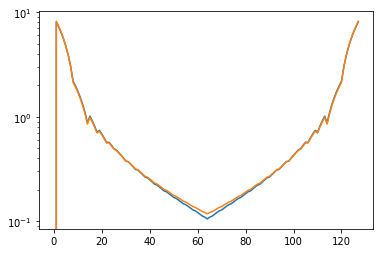

In [164]:
semilogy(power_map_1[0])
semilogy(power_map_2[0])

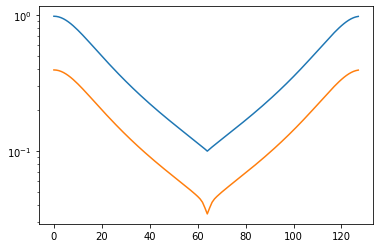

In [156]:
semilogy(power_map_1[15])
semilogy(power_map_2[15])